## Run the below import cell first

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

# The four cells below this one will create the same type of DF used in the tutorial. Next step, killing my CPU or GPU

**NOTE**: I think eventually I'd like to add other information in here, such as the sector IDs and such for the symbols.

In [3]:
# One

conn = sqlite3.connect('stockPrediction.db')

query = "SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM price_history l INNER JOIN stock r ON r.stock_id = l.stock_id;"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

# columns = pd.MultiIndex.from_product([[i for i in symbols], ['open_price', 'high_price', 'low_price', 'close_price']], names=['symbol', 'type'])

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])

In [4]:
# cell to drop all rows w/ timestamps at weird times (not 00 seconds)
df = df.reset_index()
df['price_datetime'] = pd.to_datetime(df['price_datetime'])

df = df.loc[df['price_datetime'].dt.second == 0]
df = df.loc[(df['price_datetime'].dt.minute == 0) | (df['price_datetime'].dt.minute == 15) | (df['price_datetime'].dt.minute == 30) | (df['price_datetime'].dt.minute == 45)]
df = df.set_index(['stock_symbol', 'price_datetime'])

In [ ]:
df

In [5]:
# Two

# remove stocks w/ less than 1000 data points
s = df.groupby(level=0).size()
s = s.where(s > 1000).dropna()
dfs = s.to_frame()
dfs = dfs.reset_index()
df = df.reset_index()
dfs

,stock_symbol,0
0,AACG,1513.0
1,AAGFF,1479.0
2,AAIC,1582.0
3,AAME,1513.0
4,AAU,1586.0
...,...,...
1090,ZNOG,1522.0
1091,ZOM,1534.0
1092,ZSAN,1534.0
1093,ZVO,1528.0


In [6]:
# Three
df = pd.merge(df, dfs, how='inner', left_on='stock_symbol', right_on='stock_symbol', left_index=True)
df = df.drop_duplicates()
# this line below added in on 5/14 22:37:
df = df.drop(columns=[0])
df

,stock_symbol,price_datetime,open_price,high_price,low_price,close_price,volume,dividends,stock_splits
150,BLPH,2021-02-11 09:30:00,8.300000,8.400000,8.200000,8.200000,8052.0,0.0,0
150,BLPH,2021-02-11 09:45:00,8.232900,8.232900,8.060000,8.060000,1669.0,0.0,0
150,BLPH,2021-02-11 10:00:00,8.130000,8.130000,8.130000,8.130000,232.0,0.0,0
150,BLPH,2021-02-11 10:30:00,8.210000,8.270000,8.120000,8.199400,2190.0,0.0,0
150,BLPH,2021-02-11 10:45:00,8.260000,8.260000,8.140000,8.140000,505.0,0.0,0
...,...,...,...,...,...,...,...,...,...
421,GME,2021-05-10 14:45:00,145.356003,145.356003,143.360001,144.059998,155323.0,0.0,0
421,GME,2021-05-10 15:00:00,143.860001,145.470001,143.827103,144.535004,137988.0,0.0,0
421,GME,2021-05-10 15:15:00,144.520004,144.990005,143.809998,144.020004,134012.0,0.0,0
421,GME,2021-05-10 15:30:00,144.071793,144.539993,143.250000,143.257004,178830.0,0.0,0


In [ ]:
# Five?
# Imputing to remove NaN's
impute_columns = []
imputer = KNNImputer(n_neighbors=2, weights='uniform')
imputed_data = imputer.fit_transform(df[['open_price', 'high_price', 'low_price', 'close_price', 'volume', 'dividends']])
clean_data = pd.DataFrame(imputed_data, columns=['open_price', 'high_price', 'low_price', 'close_price', 'volume', 'dividends'])
df = pd.merge(df, clean_data)

In [ ]:
df = df.drop_duplicates()
df

In [ ]:
# Four

# df = df.drop_duplicates(subset=['price_datetime'])
df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])
df

## ** TO DO **
Need to write something that eliminates all of the NaN values in the dataframe, or gets rid of the symbol entirely. The Imputer doesn't seem to be working the way it should be.

In [ ]:
df[['close_price']]

In [ ]:
df['close_price'].isnull().sum()

In [ ]:
df.reset_index()

In [ ]:
df.close_price.columns

In [2]:
# condensing several of the above cells into this one
# One

conn = sqlite3.connect('stockPrediction.db')

query = "SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM price_history l INNER JOIN stock r ON r.stock_id = l.stock_id;"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

# columns = pd.MultiIndex.from_product([[i for i in symbols], ['open_price', 'high_price', 'low_price', 'close_price']], names=['symbol', 'type'])

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])

# Two

# remove stocks w/ less than 1000 data points
s = df.groupby(level=0).size()
# s = s.where(s > 1000).dropna()
s = s.where(s > 1550).dropna()  # playing around w/ different values here to get a model that can actually be trained
dfs = s.to_frame()
dfs = dfs.reset_index()
df = df.reset_index()
# dfs

# Three
df = pd.merge(df, dfs, how='inner', left_on='stock_symbol', right_on='stock_symbol', left_index=True)
df = df.drop_duplicates()
# this line below added in on 5/14 22:37:
df = df.drop(columns=[0])

# Four

# df = df.drop_duplicates(subset=['price_datetime'])
df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])
df

open_price                                          \
stock_symbol              AAIC       AAU    ABEO   ABEV    ABIO   ABML   
price_datetime                                                           
2021-02-11 09:30:00      3.690  0.963900  3.4550  2.820  5.2885  3.720   
2021-02-11 09:45:00      3.710  0.918901  3.3796  2.855  5.4800  3.690   
2021-02-11 10:00:00      3.740  0.936800  3.3070  2.830  5.4200  3.670   
2021-02-11 10:15:00      3.740  0.939900  3.2886  2.835  5.3500  3.620   
2021-02-11 10:30:00      3.730  0.947001  3.3300  2.830  5.3900  3.610   
...                        ...       ...     ...    ...     ...    ...   
2021-05-10 14:45:00      4.065  0.542500  1.3801  3.215  3.1080  1.630   
2021-05-10 15:00:00      4.055  0.540000  1.3900  3.200  3.1000  1.595   
2021-05-10 15:15:00      4.060  0.540041  1.3850  3.200  3.1100  1.575   
2021-05-10 15:30:00      4.045  0.540900  1.3850  3.210  3.0950  1.590   
2021-05-10 15:45:00      4.045  0.540900  1.3850  3.215  3.0850  1.580   

                                                      ... stock_splits      \
stock_symbol           ABUS    ACRX     ACST    ACTG  ...          CEI DSS   
price_datetime                                        ...                    
2021-02-11 09:30:00  4.4100  2.6300  1.17000  8.2400  ...          NaN   0   
2021-02-11 09:45:00  4.4213  2.5486  1.15010  7.8500  ...          NaN   0   
2021-02-11 10:00:00  4.5393  2.5400  1.12890  7.9000  ...          NaN   0   
2021-02-11 10:15:00  4.5900  2.5750  1.11500  7.8401  ...          NaN   0   
2021-02-11 10:30:00  4.5200  2.6014  1.14000  7.8200  ...          NaN   0   
...                     ...     ...      ...     ...  ...          ...  ..   
2021-05-10 14:45:00  2.6650  1.1100  0.44690  5.6950  ...            0   0   
2021-05-10 15:00:00  2.6700  1.1100  0.44770  5.6500  ...            0   0   
2021-05-10 15:15:00  2.6900  1.1100  0.44400  5.6600  ...            0   0   
2021-05-10 15:30:00  2.6700  1.1100  0.43651  5.6000  ...            0   0   
2021-05-10 15:45:00  2.6550  1.1150  0.44910  5.6000  ...            0   0   

                                                            
stock_symbol        FCEL HIMX HTBX IMGN INO PACB PLUG VERI  
price_datetime                                              
2021-02-11 09:30:00    0    0    0    0   0    0    0    0  
2021-02-11 09:45:00    0    0    0    0   0    0    0    0  
2021-02-11 10:00:00    0    0    0    0   0    0    0    0  
2021-02-11 10:15:00    0    0    0    0   0    0    0    0  
2021-02-11 10:30:00    0    0    0    0   0    0    0    0  
...                  ...  ...  ...  ...  ..  ...  ...  ...  
2021-05-10 14:45:00    0    0    0    0   0    0    0    0  
2021-05-10 15:00:00    0    0    0    0   0    0    0    0  
2021-05-10 15:15:00    0    0    0    0   0    0    0    0  
2021-05-10 15:30:00    0    0    0    0   0    0    0    0  
2021-05-10 15:45:00    0    0    0    0   0    0    0    0  

[1588 rows x 833 columns]

In [11]:
df.close_price.count()

stock_symbol
AAIC    1582
AAU     1586
ABEO    1586
ABEV    1586
ABIO    1585
        ... 
IMGN    1586
INO     1586
PACB    1586
PLUG    1586
VERI    1586
Length: 119, dtype: int64

In [9]:
df.close_price.count().min()

1501

In [3]:
# attempting once again to impute
columns = df.close_price.columns
df = df.reset_index()
imputer = KNNImputer(n_neighbors=10, weights='uniform')
imputed_data = imputer.fit_transform(df[['close_price']])
clean_data = pd.DataFrame(imputed_data, columns=columns)
# clean_data['price_datetime'] = df['price_datetime']
# df = pd.merge(df, clean_data, on='price_datetime')
clean_data

stock_symbol,AAIC,AAU,ABEO,ABEV,ABIO,ABML,ABUS,ACRX,ACST,ACTG,...,CEI,DSS,FCEL,HIMX,HTBX,IMGN,INO,PACB,PLUG,VERI
0,3.7270,0.920000,3.3700,2.8600,5.4354,3.6865,4.4300,2.5401,1.1600,7.85,...,1.850370,4.0500,26.930000,15.3000,11.4449,8.040,13.1919,53.064999,65.099998,48.529999
1,3.7400,0.936200,3.3043,2.8350,5.4300,3.6600,4.5400,2.5464,1.1211,7.90,...,1.850370,4.0250,26.889999,15.2000,11.6300,8.085,13.0778,52.499901,65.159897,47.700001
2,3.7400,0.932201,3.2800,2.8400,5.3500,3.6100,4.6000,2.5700,1.1100,7.84,...,1.850370,4.0863,26.930000,14.9200,11.6740,8.020,12.9800,52.700001,64.983498,47.759998
3,3.7390,0.948600,3.3281,2.8311,5.3700,3.6200,4.5292,2.6050,1.1500,7.83,...,1.850370,4.0600,26.860001,15.2399,11.6601,8.080,13.1500,52.395000,65.000000,48.040001
4,3.7250,0.999800,3.3106,2.8300,5.4111,3.6145,4.5150,2.6350,1.1150,7.80,...,1.852330,4.2300,26.870001,15.1850,11.9600,8.130,13.0813,51.939999,65.040001,48.259998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1583,4.0525,0.540000,1.3850,3.2050,3.0910,1.6000,2.6700,1.1102,0.4472,5.64,...,0.664300,2.8000,7.320000,12.2200,6.2500,6.670,6.7346,23.135000,20.508801,18.940001
1584,4.0600,0.540799,1.3850,3.2000,3.1000,1.5700,2.6900,1.1100,0.4441,5.68,...,0.645100,2.8100,7.327400,12.3000,6.2950,6.625,6.7300,23.270000,20.480000,19.004999
1585,4.0450,0.540800,1.3842,3.2098,3.1000,1.5900,2.6642,1.1100,0.4366,5.59,...,0.654799,2.8011,7.290000,12.3370,6.2750,6.600,6.7200,23.250000,20.320000,19.059999
1586,4.0450,0.540900,1.3900,3.2150,3.0900,1.5700,2.6550,1.1200,0.4490,5.60,...,0.648300,2.8050,7.275000,12.4100,6.3000,6.610,6.7300,23.139999,20.285000,18.900000


In [ ]:
df['close_price']

In [4]:
df['close_price'] = clean_data
df = df.set_index('price_datetime')

In [ ]:
df['close_price'].count()

## Test-train split below
Uses close prices only. Will try a future version that uses all available data.

In [5]:
# first cell for test-train split
data = df['close_price']
data = data.reset_index()

# I am doing this differently. I am using 80% as training data, 20% as test
data_size = len(data)
training_data = data.iloc[:(int(data_size * .8))]
test_data = data.iloc[(int(data_size * .8)):]

In [ ]:
data

In [6]:
# second cell for test-train split
# adding the price_datetime index back
training_data = training_data.set_index('price_datetime')
test_data = test_data.set_index('price_datetime')

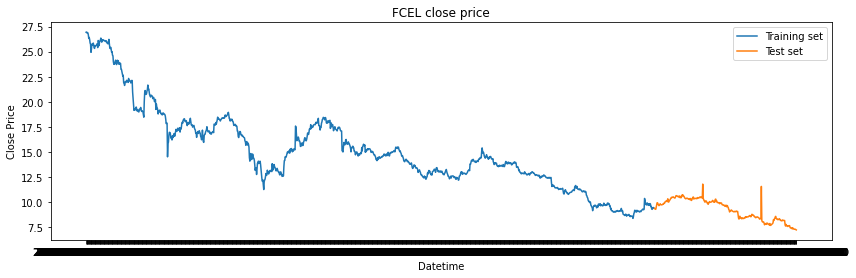

In [7]:
# testing the sets w/ matplotlib
plt.figure(figsize=(14,4))
plt.plot(training_data['FCEL'])
plt.plot(test_data['FCEL'])
plt.ylabel('Close Price')
plt.xlabel('Datetime')
plt.legend(["Training set", "Test set"])
plt.title("FCEL close price")
plt.show()

## Data Normalization
This method uses the MinMaxScaler, but a log return can sometimes be more useful. 

In [19]:
# I have altered this so it works better w/ my data.
minmax = MinMaxScaler(feature_range=(0,1))
minmax_single = MinMaxScaler(feature_range=(0,1))

# no idea if the line below will work the way I need it to or not
train_scaled = np.concatenate([minmax.fit_transform(training_data.values)], axis=1)

train_scaled = pd.DataFrame(train_scaled, columns=training_data.columns)
train_scaled

ValueError: Shape of passed values is (1270, 120), indices imply (1270, 119)

In [20]:
# validate min/max values
train_scaled.describe()

stock_symbol,AAIC,AAU,ABEO,ABEV,ABIO,ABML,ABUS,ACRX,ACST,ACTG,...,CEI,DSS,FCEL,HIMX,HTBX,IMGN,INO,PACB,PLUG,VERI
count,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,...,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000,1270.000000
mean,0.530813,0.336095,0.321305,0.617586,0.369298,0.357854,0.396819,0.428614,0.363131,0.330821,...,0.278105,0.453537,0.364416,0.487185,0.314880,0.399049,0.281025,0.329874,0.380649,0.356529
std,0.169266,0.248379,0.192903,0.186562,0.240408,0.249996,0.254568,0.233420,0.227469,0.221655,...,0.198942,0.236832,0.217730,0.203247,0.203649,0.203630,0.232293,0.190063,0.250780,0.236695
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.446666,0.145733,0.184450,0.518608,0.164384,0.170256,0.199955,0.279900,0.210521,0.166549,...,0.159926,0.278208,0.232807,0.317111,0.174673,0.255346,0.111597,0.208913,0.198323,0.144497
50%,0.506667,0.271345,0.325688,0.629698,0.365297,0.286954,0.315476,0.410299,0.349686,0.267855,...,0.238942,0.447268,0.328479,0.466656,0.302239,0.415025,0.192736,0.293133,0.326715,0.270782
75%,0.586667,0.515729,0.435780,0.740789,0.505822,0.509166,0.538690,0.578073,0.445486,0.463541,...,0.368001,0.642312,0.487252,0.623450,0.409613,0.524761,0.330794,0.356594,0.551031,0.544252
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Shaping data for LSTM

In [9]:
train_scaled = train_scaled.values
n_lags = int(60) # not sure why hard 60
X_train = []
y_train = []
for i in range(n_lags, train_scaled.shape[0]):
    X_train.append(train_scaled[i-n_lags:i])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

# check shape (again) before start training
'''shape_chk = []
for i in train_scaled.close_price.columns:
    index = {}
    index["X_train"] = X_train.shape
    index["y_train"] = y_train.shape
    shape_chk.append(index)
pd.DataFrame(shape_chk)'''

'shape_chk = []\nfor i in train_scaled.close_price.columns:\n    index = {}\n    index["X_train"] = X_train.shape\n    index["y_train"] = y_train.shape\n    shape_chk.append(index)\npd.DataFrame(shape_chk)'

In [22]:
X_train.shape, y_train.shape

((1210, 60, 119), (1210,))

## Build the LSTM network

In [10]:
%time

# LSTM architecture
regressor = tf.keras.Sequential()

# Layer 1, w/ dropout regularisation
regressor.add(tf.keras.layers.LSTM(units=20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(tf.keras.layers.Dropout(0.3))

# Layer 2
regressor.add(tf.keras.layers.LSTM(units=20, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.3))

# Layer 3
regressor.add(tf.keras.layers.LSTM(units=20, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.6))

# Layer 4
regressor.add(tf.keras.layers.LSTM(units=20))
regressor.add(tf.keras.layers.Dropout(0.6))

# Output layer
regressor.add(tf.keras.layers.Dense(units=1))

# Compile LSTM
regressor.compile(optimizer='adam', loss='mean_squared_error')

# fit to training set
for i in training_data.columns:
    print("Fitting to", i)
    regressor.fit(X_train, y_train, epochs=10, batch_size=32)

poch 6/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0024
Epoch 7/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0023
Epoch 8/10
38/38 [==============================] - 0s 11ms/step - loss: 0.0023
Epoch 9/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0022
Epoch 10/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0022
Fitting to BRQS
Epoch 1/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0023
Epoch 2/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0023
Epoch 3/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0025
Epoch 4/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0021
Epoch 5/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0025
Epoch 6/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0021
Epoch 7/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0024
Epoch 8/10
38/38 [======

In [11]:
regressor.save('model_05172021')

INFO:tensorflow:Assets written to: model_05172021\assets
INFO:tensorflow:Assets written to: model_05172021\assets


## Predicting future values using the Test set
To predict future prices, need to do a couple of data processing tasks
1. Merge training and test datasets on 0 axis.
2. set the n_lags as time steps
3. transform the new dataset
4. reshape the dataset

In [12]:
inputs

NameError: name 'inputs' is not defined

In [17]:
total_data = pd.concat((training_data, test_data), axis=0)
inputs = total_data[len(total_data) - len(test_data) - 60:]

test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(inputs['FCEL'])], axis=1)
print('Shape of test data:', test_scaled.shape)

# shaping test data from neural network
X_test = []
y_test = []
for i in range(60, test_scaled.shape[0]):
    X_test.append(test_scaled[i-n_lags:i])
    y_test.append(test_scaled[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

Now, inverse the transformed data to get back the prices in a normal readable format.

In [20]:
predicted_price = regressor.predict(X_test)
predicted_price = minmax.inverse_transform(predicted_price)
predicted_price = pd.DataFrame(predicted_price)
predicted_price.rename(columns = {0: 'FCEL_predicted'}, inplace=True)
predicted_price = predicted_price.round(decimals=2)
predicted_price.index = test_data.index

ValueError: non-broadcastable output operand with shape (318,1) doesn't match the broadcast shape (318,119)